In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
X = pd.read_csv('forestfires.csv')
y, X = X['area'], X.drop('area', axis=1)

In [3]:
X.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


### Добавим bias == 1.

In [4]:
bias = pd.DataFrame([1.]*len(X))
X = pd.concat([X, bias], axis=1, join_axes=[X.index])
X.columns.values[-1] = 'bias'

In [5]:
X.shape, y.shape, X.columns

((517, 13),
 (517,),
 Index([u'X', u'Y', u'month', u'day', u'FFMC', u'DMC', u'DC', u'ISI', u'temp',
        u'RH', u'wind', u'rain', u'bias'],
       dtype='object'))

### и индикатор лета

In [6]:
X['is_summer'] = [1 if (x[2]=='jun' or x[2]=='jul' or x[2]=='aug') else 0 for x in X.values]
del X['month']

In [7]:
X.tail()

,X,Y,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,bias,is_summer
512,4,3,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,1.0,1
513,2,4,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,1.0,1
514,7,4,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,1.0,1
515,1,4,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,1.0,1
516,6,3,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,1.0,0


### уберём день (почему - ниже)

In [8]:
del X['day']

Надо векторизовать категориальные признаки (сделать 12 индикаторов для месяцев и 7 индикаторов для недель), но матрица может получиться вырожденной. Для решения проблемы нулевых строчек (которые могут получиться также после нормирования) надо приписать справа к Z единичную матрицу, домноженную на очень маленький коэффициент (который подбирается как гиперпараметр), что эквивалентно L2-регуляризации. А чтобы избавиться от нулевых столбцов, лучше забыть об аналитическом решении (при больших данных и размерностях работать с матрицами очень неприятно, особенно обращать и каждый раз выкидывать нулевые столбцы) и вспомнить про градиентный спуск по ошибке MSE, который очень легко реализуется (прибавляем антиградиент MSE по вектору theta со знаком минус, домноженный на маленький коэффициент). Но у нас курс вроде бы не по машинному обучению, так что улучшение качества сейчас - не первоочередная задача.

In [9]:
from sklearn.cross_validation import train_test_split

def cross_validation_shuffle():
    return train_test_split(X, 
                            y, 
                            test_size=0.3)

### $X = Z\theta = Z_1\theta_1 + ... + Z_n\theta_n,$
### где $Z_i$ - значения i-го признака (вектор), а $\theta_i$ - вес i-го признака в модели (число)
### Воспользуемся методом наименьших квадратов:
### $ \theta' = argmin_\theta ||X-Z\theta||^2 $
$ (X−Z\theta)^2 = (X−Z\theta)^T (X−Z\theta) = X^T X − X^T Z \theta − \theta^T Z^T X + \theta^T Z^T Z \theta = $

$ = X^T X − 2X^T Z\theta + \theta^T (Z^T Z)\theta. $

$||X −Z\theta||^2$ — это число, поэтому $X^T Z\theta \ и\ \theta^T Z^T X$ — тоже числа.

Но ∀a ∈ R $a = a^T$, поэтому $X^TZ\theta = (X^TZ\theta)^T = \theta^T Z^T X.$


Дифференцируем по $\theta_i$ и приравниваем к нулю, чтобы найти минимум:

$−2(X^T Z)_i+2(\theta^T Z^T Z)_i = 0 \rightarrow $

$X^T Z − \theta^T Z^T Z = 0$ для любого $ i\rightarrow $

$ \theta^* = (Z^T Z)^{-1} Z^T X $

где X - это мой y (ответы), а Z - это мой X (объекты-признаки)

запишем в нашей нотации:

# $ \theta^* = (X^T X)^{-1} X^T y $


In [42]:
def fit_and_predict(X_train_, y_train_, X_test_):
    X_ = X_train_.values
    X_squared = np.dot(X_.transpose(), X_)
    X_squared_inv = np.linalg.matrix_power(X_squared, -1)
    X_y = np.dot (X_.transpose(), y_train_)
    thetas = np.dot(X_squared_inv,  X_y)
    return np.dot(X_test_.values, thetas)
    
def MSE(predictions, y_true):
    return np.mean((np.array(predictions) - np.array(y_true))**2.)


In [48]:
(X_train, 
 X_test, 
 y_train, 
 y_test) = cross_validation_shuffle()
predictions = fit_and_predict(X_train, y_train, X_test)
print MSE(predictions, y_test)

1150.75390549


### Число в ячейке выше = MSE, если предсказывать логнормальное распределение напрямую. Оно ооочень сильно зависит от того, как разбить выборку на train и test (от 400 до 12000). Попробуем вместо этого предсказывать его логарифм, а потом возводить в него экспоненту.


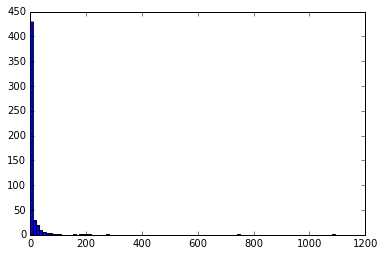

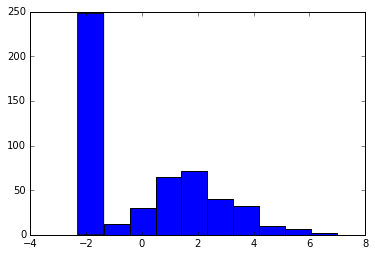

In [12]:
plt.hist(y, bins=100, label='area')
plt.show()
plt.hist(np.log(y+[0.1]*len(y)), bins=10, label='ln(area+eps)')
plt.show()

Сделайте для area преобразование f(x) = ln(c+x) и постройте для нее регрессионную
модель. Посчитайте среднеквадратичную ошибку для преобразованных значений по
данному правилу и для исходных, применив в последнем случае к оценкам обратное
к f преобразование. При каком c предсказания получаются лучше всего?


In [49]:
def fit_and_predict_lognormal(c, X_train_, y_train_, X_test_):
    y_train_log = np.log(y_train_ + [c]*len(y_train_))
    predictions = fit_and_predict(X_train, y_train_log, X_test)
    # обратное преобразование: f=ln(area+c), area=e^f-c
    return np.array([np.e**p-c for p in predictions])

best c: 42
best mse with lognormal: 0.000284059504733
mse without lognormal:  839.088323803
train_test_split ONCE:


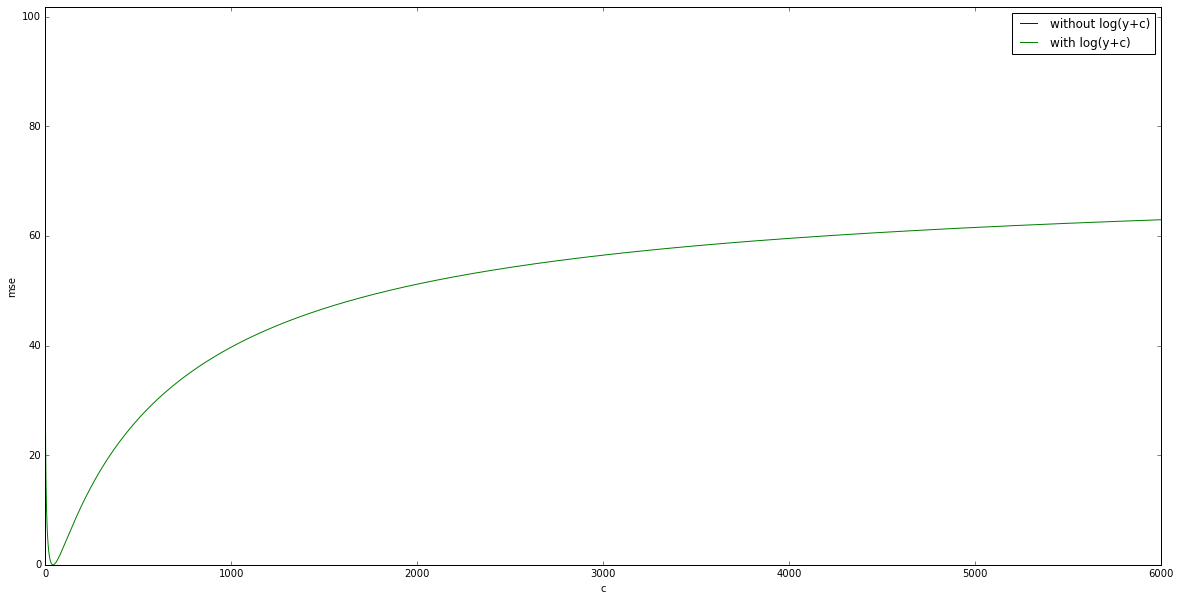

In [110]:
lognormal_mse_errors = []
min_error = 10**10
best_c = -1

(X_train, 
 X_test, 
 y_train, 
 y_test) = cross_validation_shuffle()
    
predictions = fit_and_predict(X_train, y_train, X_test)
mse_error = MSE(predictions, y_test)
    
for c in np.arange(1, 6000, 1):    
    predictions_lognormal = fit_and_predict_lognormal(c, X_train, y_train, X_test)
    lognormal_mse_errors.append(np.mean(np.array(y_test)-np.array(predictions_lognormal))**2.)
    
    if (lognormal_mse_errors[-1] < min_error):
        min_error = lognormal_mse_errors[-1]
        best_c = c

print 'best c:', best_c
print 'best mse with lognormal:', min_error
print 'mse without lognormal: ', mse_error
print 'train_test_split ONCE:'
plt.figure(figsize=(20,10))
plt.xlabel('c')
plt.ylabel('mse')
trash = plt.plot(range(len(lognormal_mse_errors)), [mse_error]*len(lognormal_mse_errors), label='without log(y+c)')
trash = plt.plot(range(len(lognormal_mse_errors)), lognormal_mse_errors, label='with log(y+c)')
plt.ylim(0, 2*np.mean(lognormal_mse_errors))
trash = plt.legend()

### Что за маленькая ошибка? Переобучение? Попробуем кросс-валидацию с сохранением хронологического порядка событий:

best mse with lognormal: 2.37720658438e-07
train_test_split ONCE, good CV:


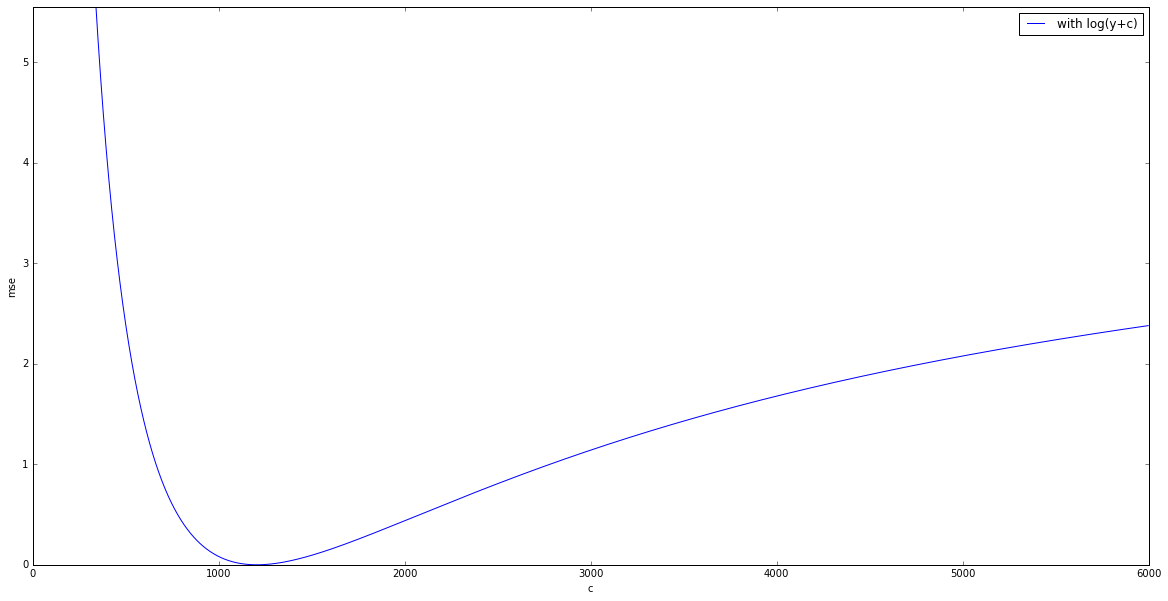

In [115]:
lognormal_mse_errors = []
min_error = 10**10

X_train = X[:int(len(X)*.7)]
X_test = X[int(len(X)*.7):]
y_train = y[:int(len(y)*.7)]
y_test = y[int(len(y)*.7):]

for c in np.arange(1, 6000, 1):    
    predictions_lognormal = fit_and_predict_lognormal(c, X_train, y_train, X_test)
    lognormal_mse_errors.append(np.mean(np.array(y_test)-np.array(predictions_lognormal))**2.)
    if (lognormal_mse_errors[-1] < min_error):
        min_error = lognormal_mse_errors[-1]

print 'best mse with lognormal:', min_error
print 'train_test_split ONCE, good CV:'
plt.figure(figsize=(20,10))
plt.xlabel('c')
plt.ylabel('mse')
trash = plt.plot(range(len(lognormal_mse_errors)), lognormal_mse_errors, label='with log(y+c)')
plt.ylim(0, 2*np.mean(lognormal_mse_errors))
trash = plt.legend()

При выбраном c сделайте разбиение выборки в соотношении 7:3 разными способа-
ми (перемешивая каждый раз). Сильно ли зависит качество от способа разбиения?
Сделайте выводы.

train_test_split EVERY TIME:


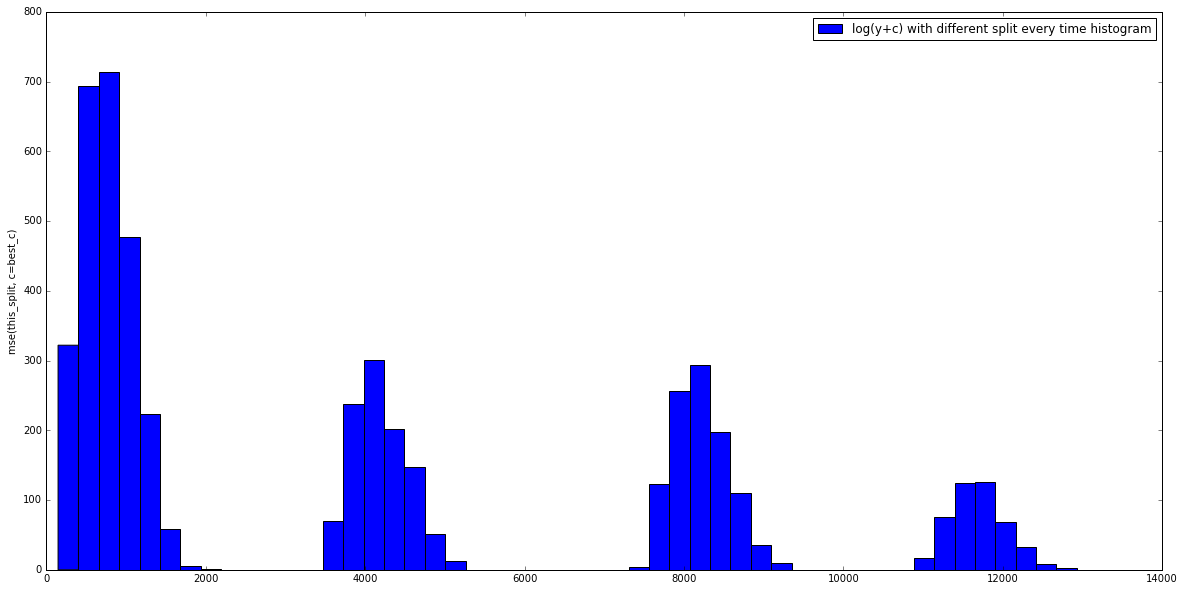

In [78]:
lognormal_mse_errors = []
    
for i in np.arange(1, 5000, 1): 
    
    (X_train, 
     X_test, 
     y_train, 
     y_test) = cross_validation_shuffle()
    
    predictions_lognormal = fit_and_predict_lognormal(best_c, X_train, y_train, X_test)
    lognormal_mse_errors.append(MSE(predictions_lognormal, y_test))

plt.figure(figsize=(20,10))
print 'train_test_split EVERY TIME:'
plt.figure(figsize=(20,10))
plt.ylabel('mse(this_split, c=best_c)')
trash = plt.hist(lognormal_mse_errors, bins=50, 
                 label='log(y+c) with different split every time histogram')
trash = plt.legend()

### распределение ошибок при фиксированном С в преобразовании ln(area+c) -> e^predict - c -> mse похоже на смесь 4 нормальных
возможно, я не прав, но разбиение выборки на train и test бывает с точки зрения этой метрики 4 видов (не очень понятно, почему)

Можно заметить, что примерно такая вероятность того, что когда мы перебираем С-шки получаем ошибку 10^-7. Очевидно, это переобучение и первый тип разбиения значит, что в train попала информация о будущем, то есть по косвенным признакам-последствиям предсказываем то, что их вызвало, а не наоборот и это очень-очень плохо (последствия очень явные, ведь тк ошибка мала, этим признакам дается большой вес). Про последний тип разбиений можно сказать, что там наоборот плохая кросс-валидация (информация о слишком разных периодах, например)

# Вывод:
### В задании сказано, что перед кросс-валидацией на train (0.7) и test (0.3) желательно перемешать выборку. Это плохо сказывается на качестве, потому что данные отсортированы по времени и мы должны предсказывать будущее, исходя из прошлого - поэтому переобучаемся. Например, была большая area в какой-то день, а на следующий это отразилось на датчиках (температура, ещё что-то, в общем, могло повлиять) - таким образом в линейной модели будут большие веса у таких "последствий" вместо больших весов у "предвестников". По-хорошему, при разбиении выборки надо сохранять хронологическую последовательность, если она есть.
### Именно поэтому наша кросс-валидация сильно зависит от рандома, так как в train каждый раз могут попасть, а могут не попасть данные из будущего относительно элементов test.

### Предсказание с преобразованием log(y+c) чувствительно к слишком большим c. Также точно можем сказать, что преобразование помогает, если взять подходящее с, но не всегда (при неудачном разбиении выборки оно может быть хуже, чем без преобразования)